# CK+ dataset : reconnaissance d'émotion

Je vais appliquer ici une approche de classification par deep learning à base de convolution neural networks à un dataset d'images obtenues sur kaggle à l'adresse https://www.kaggle.com/datasets/davilsena/ckdataset qui associent à chaque image une émotion.

Les informations données sur le site sont : 

*Contains adaptaded data up to 920 images from 920 original Cohn-Kanade Dataset (CK+) dataset.*

*Data is already reshaped to 48x48 pixels, in grayscale format and facecropped using haarcascade_frontalface_default.*

*Noisy (based on room light/hair format/skin colour) images were adapted to be clearly identified using Haar classifier.*

*Columns from file are defined as emotion/pixels/Usage*

*Emotions are defined as determined index below:*

    0 : Anger (45 samples)
    1 : Disgust (59 samples)
    2 : Fear (25 samples)
    3 : Happiness (69 samples)
    4 : Sadness (28 samples)
    5 : Surprise (83 samples)
    6 : Neutral (593 samples)
    7 : Contempt (18 samples)

*Pixels contains 2304 pixels (48x48) each row.*


# Import et lecture des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Dense, Activation, Flatten, \
                                    Dropout, Convolution2D, MaxPooling2D, Input, Resizing
import time


In [2]:
data=pd.read_csv('ckextended.csv')

In [3]:
data.head()


,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [4]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

In [5]:
print(data.shape)
print(len(data.pixels[0].split()) , 48*48)
print()

(920, 3)
2304 2304



On a 920 images de taille 48 x 48 représentées par le champ 'pixels' sous forme de chaines de caractères de longueur 2304, valant entre 0 et 255.
On a également une classe emotion qui sera notre cible, et une classe usage que je n'utiliserais pas.

## Aperçu des images

In [6]:
def df2im (df, i) :
    """Renvoit l'image correspondant à la ligne 'i' du dataframe 'df' sous forme d'un array numpy
    """
    foo=df.loc[i, 'pixels']
    im=np.reshape(foo.split(), [48,48]).astype('int')
    return im

In [7]:
emotion_list=['Anger', 'Disgust', 'Fear', 'Happiness', 'Sadness', 'Surprise', 'Neutral', 'Contempt']

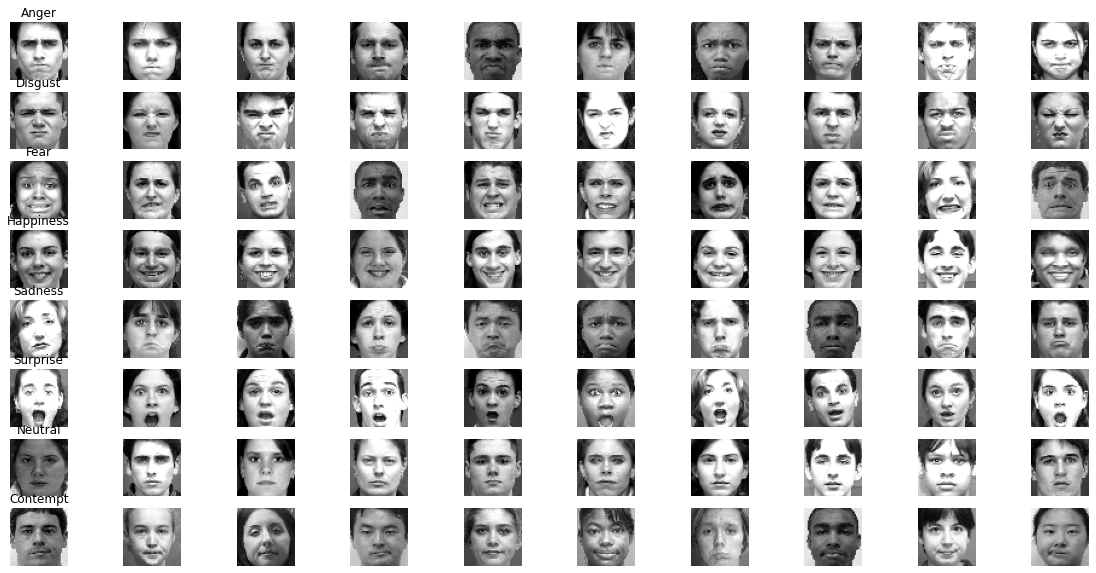

In [8]:
plt.figure(figsize=(20,10))
for i in range(8) :
    df_emo=data[data.emotion == i].reset_index(drop=True)
    for j in range(10):
        plt.subplot(8,10, i*10+j+1)
        plt.imshow( df2im(df_emo,j), cmap='gray' )
        plt.axis('off')
        if j == 0 :
            plt.title(emotion_list[i])
plt.show()

On peut voir que ce sont des personnes à qui on a demandé de surjouer des émotions. On distingue assez bien les catégories, donc le dataset a l'air utilisable, bien que les classes autres que 'neutral' aient peu de lignes. 

# Première approche

In [9]:
def affiche(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

## Définition des ensembles d'entrainement et test

On commence par regarder les résultats en adaptant directement la méthode par CNN appliquées à la reconnaissance de caractères.

In [10]:
x_temp=data.pixels
x=np.zeros((920, 2304))
for i in range(920) :
    x[i,:]=x_temp[i].split()
x/=255

x=np.reshape(x, (920, 48,48, 1) )
    
y=data.emotion


In [11]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

#On convertit les valeurs de sortie de 0 à 7 en vecteurs
Y_train = tf.keras.utils.to_categorical(y_train, 8)
Y_test = tf.keras.utils.to_categorical(y_test, 8)

x_train.shape, x_test.shape, y_train.shape, Y_train.shape, Y_test.shape

((828, 48, 48, 1), (92, 48, 48, 1), (828,), (828, 8), (92, 8))

In [12]:
inputs = Input(shape=(48,48,1)) 
tens = Convolution2D(32, kernel_size = (3, 3), activation='relu' )(inputs) 
tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
tens = MaxPooling2D((3, 3))(tens) 
tens = Flatten()(tens) 
tens = Dense(256, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 
outputs= Dense(8, activation='softmax')(tens) 
model = Model(inputs, outputs) 
model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)               (None, 256)               3211520   
                                                             

In [13]:
lr= 0.8
moment=0.8
batch_size=50
epochs=10
sgd1= tf.keras.optimizers.SGD(learning_rate=lr,momentum=moment)
model.compile(loss='categorical_crossentropy', optimizer=sgd1, metrics=['accuracy'])
tps1 = time.perf_counter()
history =model.fit(x_train, Y_train, batch_size=batch_size, epochs=epochs, 
                   verbose=1,validation_data=(x_test, Y_test))
tps2 = time.perf_counter()

print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

Epoch 1/10
17/17 [==============================] - 3s 134ms/step - loss: 25071556034318337796017750016.0000 - accuracy: 0.4638 - val_loss: 2.1614 - val_accuracy: 0.5652
Epoch 2/10
17/17 [==============================] - 2s 122ms/step - loss: 1.4375 - accuracy: 0.6534 - val_loss: 1.5833 - val_accuracy: 0.5652
Epoch 3/10
17/17 [==============================] - 2s 129ms/step - loss: 1.2978 - accuracy: 0.6534 - val_loss: 1.5432 - val_accuracy: 0.5652
Epoch 4/10
17/17 [==============================] - 2s 132ms/step - loss: 1.2887 - accuracy: 0.6534 - val_loss: 1.5119 - val_accuracy: 0.5652
Epoch 5/10
17/17 [==============================] - 2s 122ms/step - loss: 1.2878 - accuracy: 0.6534 - val_loss: 1.5186 - val_accuracy: 0.5652
Epoch 6/10
17/17 [==============================] - 2s 127ms/step - loss: 1.2833 - accuracy: 0.6534 - val_loss: 1.5370 - val_accuracy: 0.5652
Epoch 7/10
17/17 [==============================] - 2s 129ms/step - loss: 1.2846 - accuracy: 0.6534 - val_loss: 1.5038 -

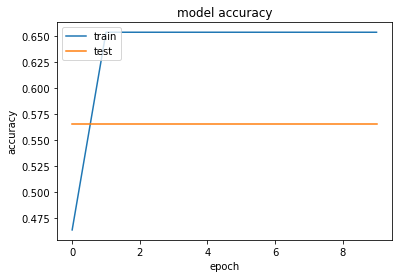

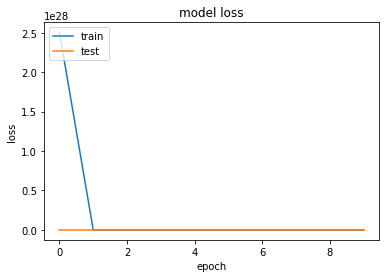

In [14]:
affiche(history) #donnee en annexe

In [15]:
y_pred = model.predict(x_test)
y_pred = y_pred.argmax(axis=-1)
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred))

3/3 [==============================] - 0s 21ms/step
Confusion Matrix
[[ 0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  4  0]
 [ 0  0  0  0  0  0  6  0]
 [ 0  0  0  0  0  0 52  0]
 [ 0  0  0  0  0  0  3  0]]


L'approche actuel ne marche pas : toutes les images sont classées dans la même catégorie ('neutral', soit la plus nombreuse, mais j'ai eu une fois tous les résultats dans une autre colonne sur 5 ou 6 essais).

On a également une convergence quasi-immédiate sans évolution par la suite, et un overfitting marqué.

## Observation plus poussée des images

La méthode actuelle n'identifie pas les features voulues. 
Visuellement, on s'attend à ce que la forme des yeux et de la bouche soient des éléments importants pour la classification. 
Et identifier des traits prenant des directions différentes selon la classe devrait être ce que les convolutions détectent bien, donc l'approche suivie n'a pas l'air aberrante. 

On va tracer de quoi a l'air une image après convolution pour voir.

In [27]:
#Version basique de la convolution en supposant la 2e image 3x3 , et les 2 images carrées :
def conv2d(im1, ker) :
    N=im1.shape[0]
    Nk=ker.shape[0]
    im_out=np.zeros((N,N))
    for i in range(1,N-1) :
        for j in range(1,N-1) :
            for di in range(3) :
                for dj in range(3) :
                    im_out[i,j]+=im1[i+di-1,j+dj-1]*ker[Nk-di-1,Nk-dj-1]
    im_out=im_out[1:N-1, 1:N-1]
    return im_out


In [28]:
#Génération des images
im_in=x_train[1].reshape(48,48)

kernel_v=np.array([[1,1,1],[0,0,0],[-1,-1,-1]])
im_v=conv2d(im_in, kernel_v)

kernel_h=np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
im_h=conv2d(im_in, kernel_h)

(-0.5, 45.5, 45.5, -0.5)

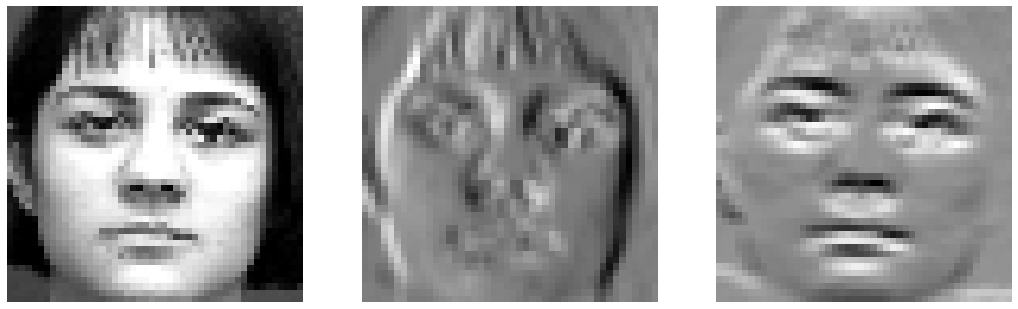

In [30]:
#Tracé des images
plt.figure(figsize=(18,6))

plt.subplot(131)
plt.imshow(im_in, cmap='gray' )
plt.axis('off')
plt.subplot(132)
plt.imshow(im_h, cmap='gray' )
plt.axis('off')
plt.subplot(133)
plt.imshow(im_v, cmap='gray' )
plt.axis('off')

L'image de droite, avec un gradient vertical, fait bien ressortir la forme de la bouche et des sourcils. Le nez est aussi bien visible, ce qui pourrait constituer un bruit.

Une approche pourrait être de mettre à zero les points loin des yeux et de la bouche, mais je m'attends à ce que ce soit déjà fait par le réseau de neurones.

L'introduction mentionne le filtrage de haar. Et je vois des références à cela en rapport avec tensorflow, donc je regarde cela dans la soirée.